379/379 [==============================] - 1s 3ms/step


/Users/igormol/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


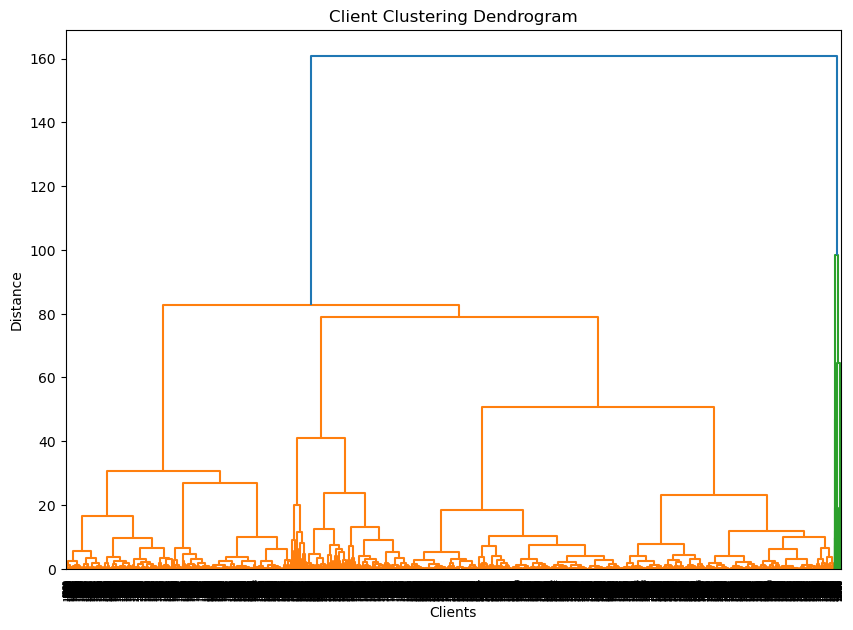

                                               Client_ID      Cluster
0                           100 LIMITES TRANSPORTES LTDA  Gold-client
1      14 DE AGOSTO COMERCIO E TRANSPORTE DE CEREAIS ...  Gold-client
2                                   153 TRANSPORTES LTDA  Gold-client
3               16.978.278 ERASMO CARLOS DE SOUSA VARGAS  Hibernating
4                    19.450.581 JARDEL DE ABREU SANDOVAL  Rising-star
...                                                  ...          ...
12103                              ZOOM TRANSPORTES LTDA  Gold-client
12104                  ZOPONE ENGENHARIA E COMERCIO LTDA  Gold-client
12105                            ZORTEA CONSTRUCOES LTDA  Hibernating
12106                     ZT COMERCIO E TRANSPORTES LTDA  Hibernating
12107                          ZUCOLOTO TRANSPORTES LTDA  Gold-client

[12108 rows x 2 columns]


In [1]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.cluster.hierarchy as shc

# Load and preprocess the data
file_path = '/Users/igormol/Desktop/Analytics_Fusion/sample/Marajo.csv'
data = pd.read_csv(file_path)

# Handle missing Brand_Name
data['Brand_Name'].fillna('Unknown', inplace=True)

# Convert Sales_Date to datetime
data['Sales_Date'] = pd.to_datetime(data['Sales_Date'])

# Calculate RFM scores
today = datetime.now()
data['Recency'] = (today - data['Sales_Date']).dt.days
rfm = data.groupby('Client_ID').agg({
    'Recency': 'min',
    'Sales_Date': 'count',  # Frequency
    'Monetary_Value': 'sum'  # Monetary
}).rename(columns={'Sales_Date': 'Frequency'}).reset_index()

# Normalize RFM scores
scaler = StandardScaler()
rfm[['Recency', 'Frequency', 'Monetary_Value']] = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary_Value']])

# Define Deep Clustering Network
class DCN(models.Model):
    def __init__(self, input_dim, latent_dim):
        super(DCN, self).__init__()
        self.encoder = models.Sequential([
            layers.InputLayer(input_shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = models.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(input_dim, activation=None)
        ])

    def call(self, inputs):
        latent = self.encoder(inputs)
        reconstructed = self.decoder(latent)
        return reconstructed

input_dim = rfm.shape[1] - 1  # Exclude Client_ID
latent_dim = 3
dcn = DCN(input_dim, latent_dim)
dcn.compile(optimizer='adam', loss='mse')

# Train the DCN
features = rfm[['Recency', 'Frequency', 'Monetary_Value']].values
dcn.fit(features, features, epochs=100, batch_size=32, verbose=0)

# Extract latent features
latent_features = dcn.encoder.predict(features)

# Cluster using k-means
kmeans = KMeans(n_clusters=7, random_state=0).fit(latent_features)
rfm['Cluster'] = kmeans.labels_

# Define cluster names
cluster_names = ["Gold-client", "VIP", "Rising-star", "Declining-client", "Hibernating", "Sleeping", "Lost"]
rfm['Cluster'] = rfm['Cluster'].map(dict(zip(range(7), cluster_names)))

# Plot tree chart
plt.figure(figsize=(10, 7))
dendrogram = shc.dendrogram(shc.linkage(latent_features, method='ward'))
plt.title('Client Clustering Dendrogram')
plt.xlabel('Clients')
plt.ylabel('Distance')
plt.show()

# Print the table with clients and their clusters
print(rfm[['Client_ID', 'Cluster']])


In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import tensorflow as tf
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt
import squarify
import multiprocessing as mp

# Load and preprocess the data
file_path = '/Users/igormol/Desktop/Analytics_Fusion/sample/Marajo.csv'
data = pd.read_csv(file_path)

# Handle missing Brand_Name
data['Brand_Name'].fillna('Unknown', inplace=True)

# Convert Sales_Date to datetime
data['Sales_Date'] = pd.to_datetime(data['Sales_Date'])

# Function to calculate RFM scores
def calculate_rfm(client_data):
    today = datetime.now()
    recency = (today - client_data['Sales_Date']).min().days
    frequency = client_data['Sales_Date'].count()
    monetary_value = client_data['Monetary_Value'].sum()
    return client_data['Client_ID'].iloc[0], recency, frequency, monetary_value

# Use parallel processing to compute RFM scores
clients = data.groupby('Client_ID')
with mp.Pool(mp.cpu_count()) as pool:
    rfm_scores = pool.map(calculate_rfm, [clients.get_group(client) for client in clients.groups])

# Create a DataFrame for RFM scores
rfm = pd.DataFrame(rfm_scores, columns=['Client_ID', 'Recency', 'Frequency', 'Monetary_Value'])

# Normalize RFM scores
scaler = StandardScaler()
rfm[['Recency', 'Frequency', 'Monetary_Value']] = scaler.fit_transform(rfm[['Recency', 'Frequency', 'Monetary_Value']])

# Define Deep Clustering Network
class DCN(models.Model):
    def __init__(self, input_dim, latent_dim):
        super(DCN, self).__init__()
        self.encoder = models.Sequential([
            layers.InputLayer(input_shape=(input_dim,)),
            layers.Dense(128, activation='relu'),
            layers.Dense(64, activation='relu'),
            layers.Dense(latent_dim, activation='relu')
        ])
        self.decoder = models.Sequential([
            layers.InputLayer(input_shape=(latent_dim,)),
            layers.Dense(64, activation='relu'),
            layers.Dense(128, activation='relu'),
            layers.Dense(input_dim, activation=None)
        ])

    def call(self, inputs):
        latent = self.encoder(inputs)
        reconstructed = self.decoder(latent)
        return reconstructed

input_dim = rfm.shape[1] - 1  # Exclude Client_ID
latent_dim = 3
dcn = DCN(input_dim, latent_dim)
dcn.compile(optimizer='adam', loss='mse')

# Train the DCN
features = rfm[['Recency', 'Frequency', 'Monetary_Value']].values
dcn.fit(features, features, epochs=100, batch_size=32, verbose=0)

# Extract latent features
latent_features = dcn.encoder.predict(features)

# Cluster using k-means
kmeans = KMeans(n_clusters=7, random_state=0).fit(latent_features)
rfm['Cluster'] = kmeans.labels_

# Define cluster names
cluster_names = ["Gold-client", "VIP", "Rising-star", "Declining-client", "Hibernating", "Sleeping", "Lost"]
rfm['Cluster'] = rfm['Cluster'].map(dict(zip(range(7), cluster_names)))

# Calculate the size of each cluster
cluster_counts = rfm['Cluster'].value_counts().sort_index()
sizes = cluster_counts.values
labels = cluster_counts.index

# Plot tree chart
plt.figure(figsize=(12, 8))
squarify.plot(sizes=sizes, label=labels, alpha=.8)
plt.axis('off')
plt.title('Client Clustering Treemap')
plt.show()

# Print the table with clients and their clusters
print(rfm[['Client_ID', 'Cluster']])


Process SpawnPoolWorker-3:
Traceback (most recent call last):
  File "/Users/igormol/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/igormol/anaconda3/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/igormol/anaconda3/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/Users/igormol/anaconda3/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'calculate_rfm' on <module '__main__' (built-in)>
Process SpawnPoolWorker-1:
Traceback (most recent call last):
  File "/Users/igormol/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/igormol/anaconda3/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._arg

Process SpawnPoolWorker-13:
Traceback (most recent call last):
  File "/Users/igormol/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/igormol/anaconda3/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/igormol/anaconda3/lib/python3.11/multiprocessing/pool.py", line 114, in worker
    task = get()
           ^^^^^
  File "/Users/igormol/anaconda3/lib/python3.11/multiprocessing/queues.py", line 367, in get
    return _ForkingPickler.loads(res)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^
AttributeError: Can't get attribute 'calculate_rfm' on <module '__main__' (built-in)>
Process SpawnPoolWorker-14:
Traceback (most recent call last):
  File "/Users/igormol/anaconda3/lib/python3.11/multiprocessing/process.py", line 314, in _bootstrap
    self.run()
  File "/Users/igormol/anaconda3/lib/python3.11/multiprocessing/process.py", line 108, in run
    self._target(*self._a